(introduction:analysis-frameworks)=

# Analysis frameworks and tools

## Single-cell analysis frameworks and consortia

After having obtained the count matrices, as described earlier, the exploratory data analysis phase begins. Due to the size and complexity of the data, specialized tooling is required. While in the early days of single-cell analysis people used to analyze their data with custom scripts, frameworks for specifically this purpose now exist. The three most popular options are the R based Bioconductor{cite}`at:Huber2015` and Seurat{cite}`at:Hao2021` ecosystems and the Python based scverse{cite}`scverse2022` ecosystem. These differ not only in the used programming languages, but also in the underlying data structures and available specialized analysis tools.

Bioconductor is a project which develops, supports and shares free open source software with a focus on rigorous and reproducible analysis of data for many different biological assays including single-cell. A homogeneous developer and user experience and extensive documentation with user friendly vignettes are the biggest strengths of Bioconductor. Seurat is a well regarded R package specifically designed for the analysis of single-cell data. It offers tooling for all steps of the analysis including multimodal and spatial data. The well written vignettes and the large user-base is what Seurat is known for.
However, both R options can run into scalability issues for extremely large datasets (more than half a million cells) which motivated the Python based community to develop the scverse ecosystem. scverse is an organization and an ecosystem dedicated to foundational tools in the life sciences with an initial focus on single-cell. Scalability, extendability and strong interoperability with the existing Python data and machine learning tooling are some of the advantages of the scverse ecosystem.

All three ecosystems are involved in many efforts to allow for interoperability of the involved frameworks. This will be discussed in the "Interoperability" chapter. This book always focuses on the best tools for the corresponding question and will therefore use a mix of the above-mentioned ecosystems for specific issues. However, the basis of all analyses will be the scverse ecosystem for two reasons:

1. While we will regularly switch ecosystems and even programming languages throughout this book, a consistent use of data structures and tooling helps readers to focus on the concepts and not on implementation details.
2. [A great book on exclusively the Bioconductor ecosystem](https://bioconductor.org/books/release/OSCA/) already exists. We encourage users that only want to learn about single-cell analysis with Bioconductor to read it.

In the following sections the scverse ecosystem will be introduced in more detail and the most important concepts will be explained with a focus on the most important data structures. This introduction cannot cover all aspects of the data structures and frameworks. It is not in scope to introduce all available analysis functions. We therefore refer to the respective frameworks' tutorials and documentation where required.

## Storing unimodal data with AnnData

As previously discussed, after alignment and gene annotation, genomics data is typically summarized to a feature matrix. This matrix will be of the shape `number_observations x number_variables` – where for scRNA-seq observations are cellular barcodes and the variables are annotated genes. Over the course of an analysis the observations and variables of this matrix are annotated with computationally derived measurements (e.g. quality control metrics, or latent space embeddings) and prior knowledge (e.g. source donor or alternative gene identifier). In the scverse ecosystem, AnnData{cite}Virshup2021 is used to associate the data matrix with these annotations. To allow for fast and memory efficient transformations, AnnData also supports sparse matrices and partial reading.

While AnnData is broadly similar to data structures from the R ecosystems (e.g. [Bioconductor's SummarizedExperiment](https://bioconductor.org/packages/release/bioc/html/SummarizedExperiment.html) or [Seurat's object](https://mojaveazure.github.io/seurat-object/)), R packages use a transposed feature matrix. 

At its core, an AnnData object stores a sparse or dense matrix (the count matrix in the case of scRNA-Seq) in `X`. This matrix has the dimensions of `obs_names x var_names` where the obs (=observations) correspond to the cells' barcodes and the var (=variables) correspond to the gene identifiers. This matrix `X` is surrounded by Pandas DataFrames `obs` and `var` which save annotations of cells and genes respectively. Further, AnnData saves whole matrices of calculations for the observations (`obsm`) or variables (`varm`) with the corresponding dimensions. Graph like structures which associate cells with cells or genes with genes are usually saved in `obsp` and `varp`. Any other unstructured data which does not fit any other slot is saved as unstructured data in `uns`. It is further possible to store more values of `X` in `layers`. Use cases for this are for example the storage of raw, unnormalized count data in a `counts` layer and the normalized data in the unnamed default layer.    
AnnData is primarily designed for unimodal (for example just scRNA-Seq) data. However, extensions of AnnData such as MuData, which is covered later in this chapter, allow for the efficient storage and access of multimodal data.

:::{figure-md} anndata-fig
<img src="../_static/images/analysis_tools/anndata.jpg" alt="AnnData Overview" class="bg-primary mb-1" width="800px">

AnnData overview. Image obtained from {cite}`Virshup2021`.
:::

### Installation

AnnData is available on PyPI and Conda can be installed with using either:
```bash
pip install anndata
conda install -c conda-forge anndata
```

### Initializing an AnnData object

This section is inspired by AnnData's "getting started" tutorial: https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html

Let us create a simple AnnData object with sparse count information which may for example represent gene expression counts. First, we import the required packages.

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix

As a next step we initialize an AnnData object with random poisson distributed data. It is an unwritten rule to name the primary AnnData object of the analysis `adata`.

In [2]:
counts = csr_matrix(np.random.poisson(1, size=(100, 2000)), dtype=np.float32)
adata = ad.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 100 × 2000

The obtained AnnData object has 100 observations and 2000 variables. This would correspond to 100 cells with 2000 genes. The initial data we passed are accessible as a sparse matrix using `adata.X`.

In [3]:
adata.X

<100x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 126413 stored elements in Compressed Sparse Row format>

Now, we provide the index to both the `obs` and `var` axes using `.obs_names` and `.var_names` respectively.

In [4]:
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


### Adding aligned metadata

#### Observational or Variable level

The core of our AnnData object is now in place. As a next step we add metadata at both, the observational and variable levels. Remember, we store such annotations in the `.obs` and `.var` slots of the AnnData object for cell and gene annotations respectively.

In [5]:
ct = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs["cell_type"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
adata.obs

,cell_type
Cell_0,B
Cell_1,T
Cell_2,B
Cell_3,T
Cell_4,Monocyte
...,...
Cell_95,T
Cell_96,T
Cell_97,B
Cell_98,T


If we examine the representation of the AnnData object again now, we will notice that it got updated as well with the `cell_type` information in `obs`.

In [6]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'

#### Subsetting using metadata

We can also subset the AnnData object with the randomly generated cell types. The slicing and masking of the AnnData object behaves similarly to the access of data in Pandas DataFrames or R matrices. More details on this can be found below.

In [7]:
bdata = adata[adata.obs.cell_type == "B"]
bdata

View of AnnData object with n_obs × n_vars = 26 × 2000
    obs: 'cell_type'

### Observation/variable-level matrices

We might also have metadata at either level that has many dimensions to it, such as a UMAP embedding of the data. For this type of metadata, AnnData has the `.obsm/.varm` attributes. We use keys to identify the different matrices we insert. The restriction of `.obsm/.varm` are that `.obsm` matrices must have a length equal to the number of observations as `.n_obs` and `.varm` matrices must have a length equal to `.n_vars`. They can each independently have different number of dimensions.

Let us start with a randomly generated matrix that we can interpret as a UMAP embedding of the data we would like to store, as well as some random gene-level metadata.

In [8]:
adata.obsm["X_umap"] = np.random.normal(0, 1, size=(adata.n_obs, 2))
adata.varm["gene_stuff"] = np.random.normal(0, 1, size=(adata.n_vars, 5))
adata.obsm

AxisArrays with keys: X_umap

Again, the AnnData representation is updated.

In [9]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    obsm: 'X_umap'
    varm: 'gene_stuff'

A few more notes about `.obsm/.varm`:

1. The “array-like” metadata can originate from a Pandas DataFrame, scipy sparse matrix, or numpy dense array.
2. When using scanpy, their values (columns) are not easily plotted, where instead items from `.obs` are easily plotted on, e.g., UMAP plots.


### Unstructured metadata

As mentioned above, AnnData has *.uns*, which allows for any unstructured metadata. This can be anything, like a list or a dictionary with some general information that was useful in the analysis of our data. Try to only use this slot for data which cannot be efficiently stored in the other slots.

In [10]:
adata.uns["random"] = [1, 2, 3]
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('random', [1, 2, 3])])
With overloaded keys:
	['neighbors'].

### Layers

Finally, we may have different forms of our original core data, perhaps one that is normalized and one that is not. These can be stored in different layers in AnnData. For example, let us log transform the original data and store it in a layer.

In [11]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

Our original matrix `X` was not modified and is still accessible. We can verify this by comparing the original `X` to the new layer.

In [12]:
(adata.X != adata.layers["log_transformed"]).nnz == 0

False

### Conversion to DataFrames

It is possible to obtain a Pandas DataFrame from one of the layers.

In [13]:
adata.to_df(layer="log_transformed")

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_1990,Gene_1991,Gene_1992,Gene_1993,Gene_1994,Gene_1995,Gene_1996,Gene_1997,Gene_1998,Gene_1999
Cell_0,0.693147,0.000000,1.386294,1.386294,0.693147,0.000000,0.693147,1.098612,0.000000,1.098612,...,0.693147,0.693147,0.000000,0.693147,1.098612,0.000000,0.000000,1.098612,0.693147,0.000000
Cell_1,1.098612,1.098612,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,1.386294,0.000000,...,1.098612,1.386294,1.098612,0.000000,0.693147,0.693147,1.386294,0.000000,0.000000,0.693147
Cell_2,0.693147,0.693147,1.098612,0.693147,1.386294,1.386294,0.693147,0.693147,0.000000,1.098612,...,0.000000,0.693147,0.693147,0.000000,1.386294,0.693147,0.000000,0.000000,0.693147,0.693147
Cell_3,0.000000,0.000000,0.000000,0.693147,0.693147,0.000000,1.386294,1.098612,0.693147,0.693147,...,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.000000,1.386294,0.693147
Cell_4,0.000000,0.693147,0.000000,1.609438,1.098612,0.693147,0.000000,0.000000,0.693147,0.000000,...,1.098612,1.098612,0.000000,1.386294,1.791759,1.098612,1.609438,0.693147,0.000000,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_95,0.693147,1.098612,0.693147,1.386294,1.098612,0.693147,0.000000,0.000000,0.000000,0.693147,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.693147,1.386294,0.693147
Cell_96,0.693147,0.000000,0.000000,1.098612,0.000000,0.693147,0.693147,1.098612,0.000000,0.000000,...,1.386294,0.693147,1.098612,0.693147,0.000000,0.693147,1.098612,1.386294,0.693147,0.000000
Cell_97,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.693147,...,0.000000,0.693147,1.386294,0.000000,0.000000,0.000000,0.693147,0.693147,1.609438,0.693147
Cell_98,0.693147,0.693147,0.000000,1.098612,0.000000,0.693147,0.693147,1.098612,0.000000,0.000000,...,0.000000,0.000000,0.693147,0.693147,0.000000,0.693147,1.386294,0.693147,1.098612,1.386294


### Reading and writing of AnnData objects

AnnData objects can be saved on disk to hierarchical array stores like [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) or [Zarr](https://zarr.readthedocs.io/en/stable/index.html) to enable similar structures in disk and on memory. AnnData comes with its own persistent HDF5-based file format: `h5ad`. If string columns with small number of categories are not yet categoricals, AnnData will auto-transform them to categoricals. We will now save our AnnData object in `h5ad` format.

In [14]:
adata.write("my_results.h5ad", compression="gzip")

In [15]:
!h5ls 'my_results.h5ad'

X                        Group
layers                   Group
obs                      Group
obsm                     Group
uns                      Group
var                      Group
varm                     Group


... and read it back in.

In [16]:
adata_new = ad.read_h5ad("my_results.h5ad")
adata_new

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

### Efficient data access

#### View and copies

For the fun of it, let us look at another metadata use case. Imagine that the observations come from instruments characterizing 10 readouts in a multi-year study with samples taken from different subjects at different sites. We would typically get that information in some format and then store it in a DataFrame:

In [17]:
obs_meta = pd.DataFrame(
    {
        "time_yr": np.random.choice([0, 2, 4, 8], adata.n_obs),
        "subject_id": np.random.choice(
            ["subject 1", "subject 2", "subject 4", "subject 8"], adata.n_obs
        ),
        "instrument_type": np.random.choice(["type a", "type b"], adata.n_obs),
        "site": np.random.choice(["site x", "site y"], adata.n_obs),
    },
    index=adata.obs.index,  # these are the same IDs of observations as above!
)

This is how we join the readout data with the metadata. Of course, the first argument of the following call for *X* could also just be a DataFrame. This will result in a single data container which tracks everything.

In [18]:
adata = ad.AnnData(adata.X, obs=obs_meta, var=adata.var)
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

Subsetting the joint data matrix can be important to focus on subsets of variables or observations, or to define train-test splits for a machine learning model.

 **Note** Similar to numpy arrays, AnnData objects can either hold actual data or reference another `AnnData` object. In the later case, they are referred to as "view". Subsetting AnnData objects always returns views, which has two advantages:

- no new memory is allocated
 - it is possible to modify the underlying AnnData object.
 
You can get an actual AnnData object from a view by calling `.copy()` on the view. Usually, this is not necessary, as any modification of elements of a view (calling `.[]` on an attribute of the view) internally calls `.copy()` and makes the view an AnnData object that holds actual data. See the example below. 

In [19]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

**Note** Indexing into AnnData will assume that integer arguments to `[]` behave like `.iloc` in pandas, whereas string arguments behave like `.loc`. `AnnData` always assumes string indices. 

In [20]:
adata_view = adata[:5, ["Gene_1", "Gene_3"]]
adata_view

View of AnnData object with n_obs × n_vars = 5 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

This is a view! This can be verified by examining the AnnData object again.

In [21]:
adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

The dimensions of the AnnData object have not changed it still contains the same data. If we want an AnnData that holds the data in memory we have to call `.copy()`.

In [22]:
adata_subset = adata[:5, ["Gene_1", "Gene_3"]].copy()

For a view, we can also set the first 3 elements of a column.

In [23]:
print(adata[:3, "Gene_1"].X.toarray().tolist())
adata[:3, "Gene_1"].X = [0, 0, 0]
print(adata[:3, "Gene_1"].X.toarray().tolist())

[[0.0], [2.0], [1.0]]
[[0.0], [0.0], [0.0]]


If you try to access parts of a view of an AnnData, the content will be auto-copied and a data-storing object will be generated.

In [24]:
adata_subset = adata[:3, ["Gene_1", "Gene_2"]]
adata_subset

View of AnnData object with n_obs × n_vars = 3 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'

In [25]:
adata_subset.obs["foo"] = range(3)

Trying to set attribute `.obs` of view, copying.


Now `adata_subset` stores the actual data and is no longer just a reference to adata.

In [26]:
adata_subset

AnnData object with n_obs × n_vars = 3 × 2
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site', 'foo'

Evidently, you can use all of pandas to slice with sequences or boolean indices.

In [27]:
adata[adata.obs.time_yr.isin([2, 4])].obs.head()

,time_yr,subject_id,instrument_type,site
Cell_0,4,subject 8,type b,site x
Cell_2,2,subject 2,type b,site y
Cell_3,4,subject 8,type a,site y
Cell_5,2,subject 2,type a,site y
Cell_10,2,subject 8,type b,site x


#### Partial reading of large data

If a single `h5ad` file is very large, you can partially read it into memory by using backed mode or with the currently experimental [read_elem](https://anndata.readthedocs.io/en/latest/generated/anndata.experimental.read_elem.html) API.

In [28]:
adata = ad.read("my_results.h5ad", backed="r")

In [29]:
adata.isbacked

True

If you do this, you will need to remember that the AnnData object has an open connection to the file used for reading.

In [30]:
adata.filename

PosixPath('my_results.h5ad')

As we are using it in read-only mode, we cannot damage anything. To proceed with this tutorial, we still need to explicitly close it.

In [31]:
adata.file.close()

## Unimodal data analysis with scanpy

Now that we understood the fundamental data structure of unimodal single-cell analysis, the question remains how we can actually analyze the stored data. In the scverse ecosystem several tools for the analysis of specific omics data exist. For example, scanpy{cite}`Wolf2018` provides tooling for general RNA-Seq focused analysis, squidpy{cite}`Palla2022` focuses on spatial transcriptomics and scirpy{cite}`Sturm2020` provides tooling for the analysis of T-cell receptor (TCR) and B-cell receptor (BCR) data. Even though many scverse extensions for various data modalities exist, they usually use some of scanpy's preprocessing and visualization capabilities to some extent.

More specifically, scanpy is a Python package which builds on top of AnnData to facilitate the analysis of single-cell gene expression data. Several methods for preprocessing, embedding, visualization, clustering, differential gene expression testing, pseudotime and trajectory inference, and simulation of gene regulatory networks are accessible through scanpy. The efficient implementation based on the Python data science and machine learning libraries allows scanpy to scale to millions of cells.    
Generally, best-practice single-cell data analysis is an interactive process. Many of the decisions and analysis steps depend on the results of previous steps and potentially input of experimental partners. Pipelines such as scflow{cite}`at:Khozoie2021`, which fully automate some downstream analysis steps, started to appear only recently. These pipelines have to make assumptions and simplifications which may not result in the most robust analysis.
scanpy is therefore designed to be used for interactive analyses with for example Jupyter Notebooks{cite}`jupyter`.

:::{figure-md} scanpy-fig
<img src="../_static/images/analysis_tools/scanpy.jpg" alt="scanpy Overview" class="bg-primary mb-1" width="800px">

scanpy overview. Image obtained from {cite}`Wolf2018`.
:::

### Installation

scanpy is available on PyPI and Conda can be installed with using either:
```bash
pip install scanpy
conda install -c conda-forge scanpy
```

### Scanpy API design

The scanpy framework is designed in a way that functions belonging to the same step are grouped in corresponding modules. For example, all preprocessing functions are available in the `scanpy.preprocessing` module, all transformation of a data matrix which are not preprocessing are available in `scanpy.tools` and all visualizations are available in `scanpy.plot`. These modules are commonly accessed after having imported scanpy like `import scanpy as sc` with the corresponding abbreviations `sc.pp` for preprocessing, `sc.tl` for tools and `sc.pl` for plots. All modules which read or write data are directly accessed. Further, a module for various datasets is available as `sc.datasets`.
All functions with their corresponding parameters and potentially example plots are documented in the scanpy API documentation{cite}`scanpy_api`.

Note that this tutorial only covers a very small subset of scanpy's features and options. Readers are strongly encouraged to examine [scanpy's documentation](https://scanpy.readthedocs.io/) for more details.

:::{figure-md} scanpy-api
<img src="../_static/images/analysis_tools/scanpy_api.png" alt="scanpy API" class="bg-primary mb-1" width="800px">

scanpy API overview. The API is divided into datasets, preprocessing (pp), tools (tl) and corresponding plotting (pl) functions.
:::

### Scanpy example

In the following cells we will shortly demonstrate the workflow of an analysis with scanpy. We explicitly do not conduct a full analysis because the specific analysis steps are covered in the corresponding chapters.

The dataset of choice is a dataset of 2700 peripheral blood mononuclear cells of a healthy donor which were sequenced on the Illumina NextSeq 500.

As a first step we import scanpy and define defaults for our following quick scanpy demo. We use scanpy's setting object to  set the Matplotlib plotting defaults for all of scanpy's plots and finally print scanpy's header. This header contains the versions of all relevant Python packages in the current environment including Scanpy and AnnData. This output is especially useful when reporting bugs to the scverse team and for reproducibility reasons.

In [32]:
import scanpy as sc

sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.2 pandas==1.4.3 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.10 pynndescent==0.5.5


Next, we get the 3k PBMC dataset with scanpy as an AnnData object. The dataset is automatically downloaded and saved to a path which can be also specified with scanpy's settings object. By default it is the folder `data`.

In [33]:
adata = sc.datasets.pbmc3k()
adata

100%|██████████| 5.58M/5.58M [00:01<00:00, 3.25MB/s]


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

The returned AnnData object has 2700 cells with 32738 genes. The `var` slot further contains the gene IDs.

In [34]:
adata.var

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180


As mentioned above, all of scanpy's analysis functions are accessible *via* `sc.[pp, tl, pl]`. As a first step to get an overview over our data, we use scanpy to show those genes that yield the highest fraction of counts in each single cell, across all cells. We simply call the `sc.pl.highest_expr_genes` function, pass the AnnData object which is in pretty much all cases the first parameter of any scanpy function, and specify that we want the top 20 expressed genes to be shown.

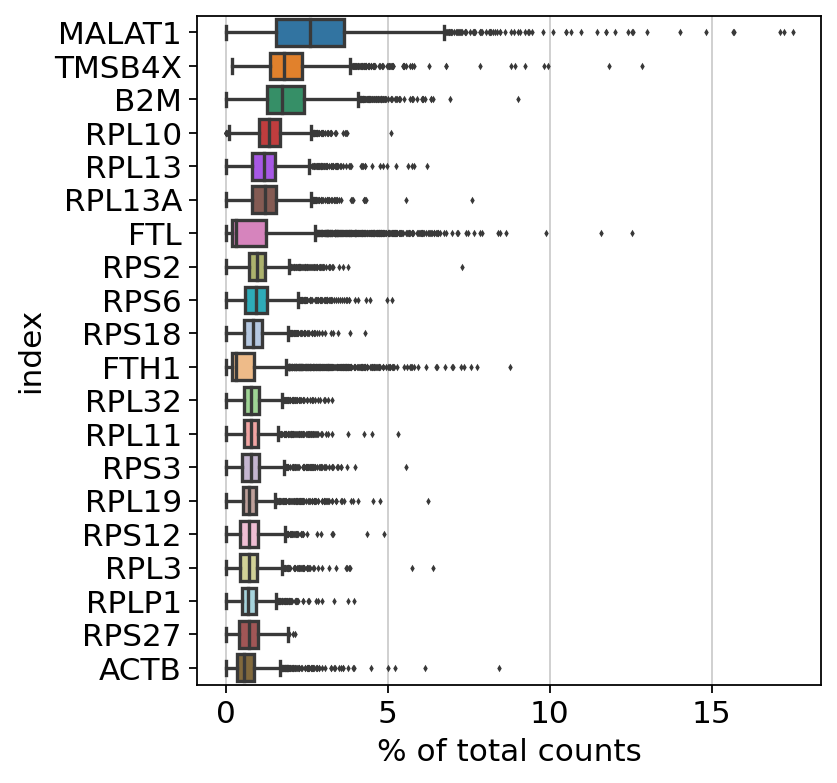

In [35]:
sc.pl.highest_expr_genes(adata, n_top=20)

Apparently, MALAT1 is the most expressed gene which is frequently detected in poly-A captured scRNA-Seq data, independent of protocol. This gene has been shown to have an inverse correlation with cell health. Especially dead/dying cells have a higher expression of MALAT1.

We now filter cells with less than 200 detected genes and genes which were found in less than 3 cells for a rough quality threshold with scanpy's preprocessing module.

In [36]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

A common step in single-cell RNA-Seq analysis is dimensionality reduction with for example principal component analysis (PCA) to unveil the main axes of variation. This also denoises the data. scanpy offers PCA as a `preprocessing` or `tools` function. These are equivalent. Here, we use the version in `tools` for no particular reason. 

In [37]:
sc.tl.pca(adata, svd_solver="arpack")

The corresponding plotting function allows us to pass genes to the color argument. The corresponding values are automatically extracted from the AnnData object.

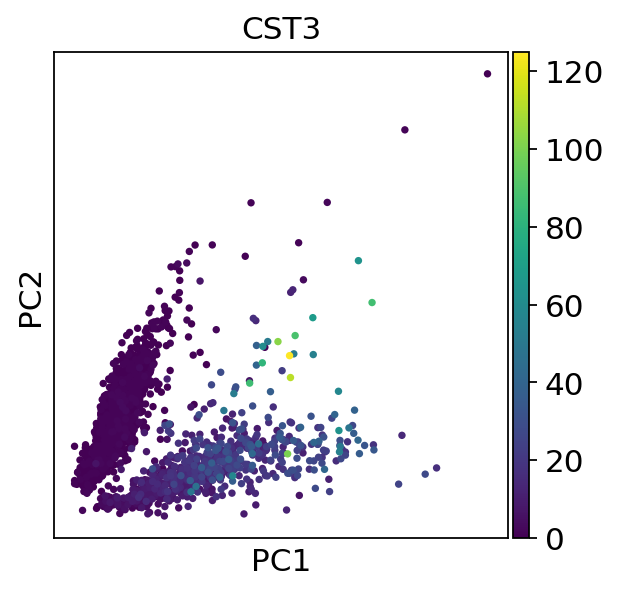

In [38]:
sc.pl.pca(adata, color="CST3")

A fundamental step for any advanced embedding and downstream calculations is the calculating of the neighborhood graph using the PCA representation of the data matrix. It is automatically used for other tools that require it such as the calculation of a UMAP.

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

We now use the calculating neighborhood graph to embed the cells with a UMAP, one of many advanced dimension reduction {term}`algorithm`s implemented in scanpy.

In [40]:
sc.tl.umap(adata)

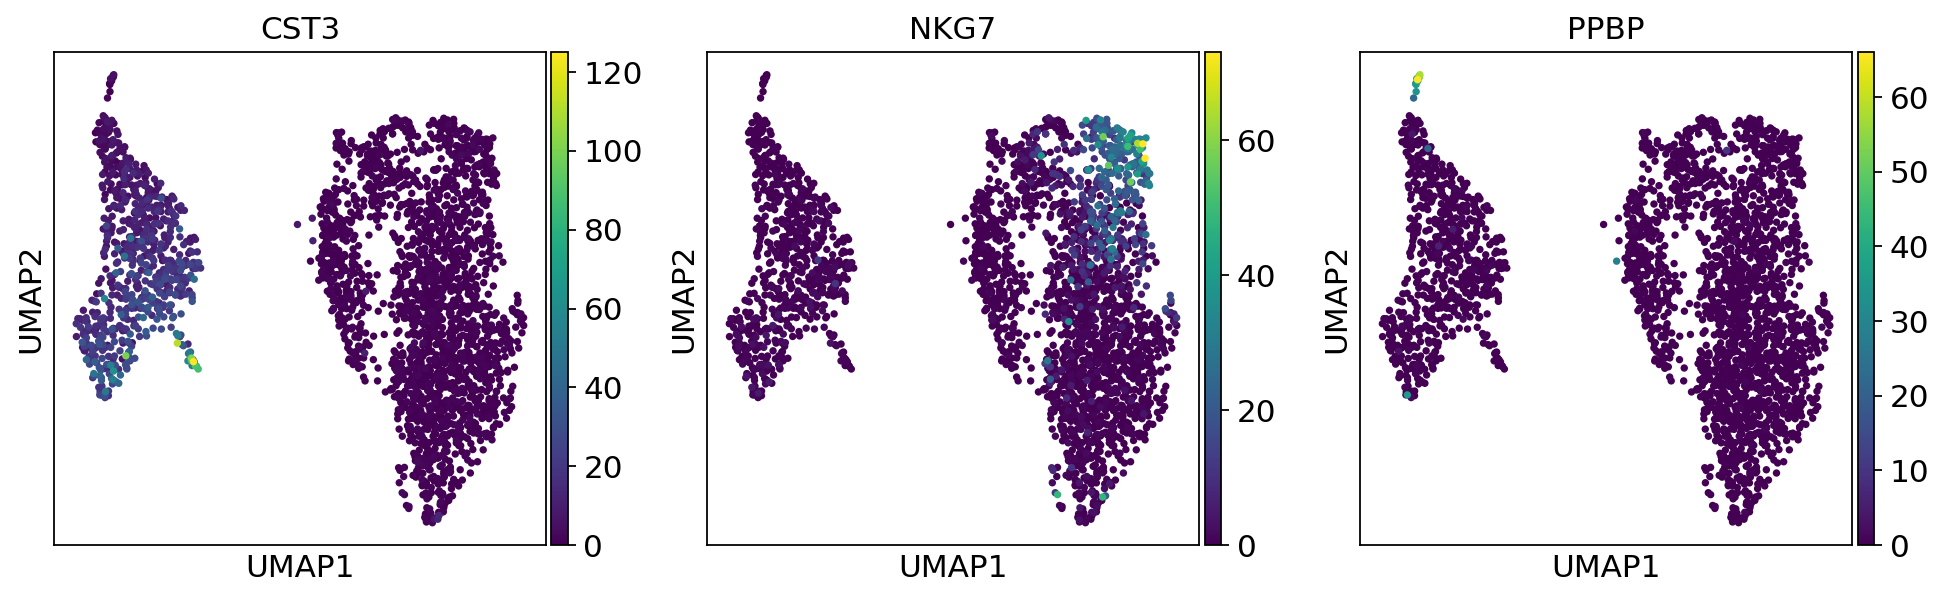

In [41]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

scanpy's documentation also provides [tutorials](https://scanpy.readthedocs.io/en/stable/tutorials.html) which we recommend to all readers who need a refresher of scanpy or are new to scanpy. Video tutorials are available on the [scverse youtube channel](https://www.youtube.com/channel/UCpsvsIAW3R5OdftJKKuLNMA).

(at:mudata)=

## Advanced: Using MuData to store multimodal data

AnnData is primarily designed for storing and manipulating unimodal data. However, multimodal assays such as CITE-Seq generate multimodal data by simultaneously measuring RNA and surface proteins. This data requires more advanced ways of storing, which is where MuData comes into play. MuData builds on top of AnnData to store and manipulate multimodal data. muon{cite}`Bredikhin2022`, a "scanpy equivalent" and core package of scverse, can then be used to analyze the multimodal omics data.
The following section is based on the MuData Quickstart tutorial{cite}`mudata_quickstart` and the Multimodal data objects tutorial{cite}`mudata_object`.

:::{figure-md} mudata-fig
<img src="../_static/images/analysis_tools/mudata.png" alt="MuData Overview" class="bg-primary mb-1" width="800px">

MuData overview. Image obtained from {cite}`Bredikhin2022`.
:::

### Installation

MuData is available on PyPI and Conda can be installed with using either:
```bash
pip install mudata
conda install -c conda-forge mudata
```

The main idea behind MuData is that the MuData object contains references to the single AnnData objects of the unimodal data, but the MuData object itself also stores multimodal annotations. It is therefore possible to directly access the AnnData objects to perform unimodal data transformations which store their results in the corresponding AnnData annotations, but also to aggregate the modalities for joint calculations whose results can be stored in the global MuData object. Technically, this is realized by MuData objects comprising a dictionary with AnnData objects, one per modality, in their `.mod` (=modality) attribute. Just as AnnData objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings.

### Initializing an MuData object

We will start by importing MuData from the mudata package.

In [42]:
import mudata as md

To create an example MuData object we require simulated data.

In [43]:
n, d, k = 1000, 100, 10

z = np.random.normal(loc=np.arange(k), scale=np.arange(k) * 2, size=(n, k))
w = np.random.normal(size=(d, k))
y = np.dot(z, w.T)
y.shape

(1000, 100)

To create a MuData object we require the unimodal AnnData objects first. Therefore, we create two AnnData objects with *data for the same observations*, but for *different variables*.

In [44]:
adata = ad.AnnData(y)
adata.obs_names = [f"obs_{i+1}" for i in range(n)]
adata.var_names = [f"var_{j+1}" for j in range(d)]
adata

AnnData object with n_obs × n_vars = 1000 × 100

In [45]:
d2 = 50
w2 = np.random.normal(size=(d2, k))
y2 = np.dot(z, w2.T)

adata2 = ad.AnnData(y2)
adata2.obs_names = [f"obs_{i+1}" for i in range(n)]
adata2.var_names = [f"var2_{j+1}" for j in range(d2)]
adata2

AnnData object with n_obs × n_vars = 1000 × 50

These two AnnData objects (two "modalities") can then be wrapped into a single MuData object. Here, we name modality one `A` and modality two `B`.

In [46]:
mdata = md.MuData({"A": adata, "B": adata2})
mdata

MuData object with n_obs × n_vars = 1000 × 150
  2 modalities
    A:	1000 x 100
    B:	1000 x 50

Observations and variables of the MuData object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique. This is reflected in the object description above: `mdata` has 1000 observations and 150 = 100+50 variables.

### MuData attributes

MuData objects consist of annotations as earlier described for AnnData objects like `.obs` or `.var`, but extend this behavior with `.mod` which serves as an accessor to the individual modalities.

Modalities are stored in a collection accessible via the `.mod` attribute of the MuData object with names of modalities as keys and AnnData objects as values.

In [47]:
list(mdata.mod.keys())

['A', 'B']

Individual modalities can be accessed with their names via the `.mod` attribute or via the MuData object itself as a shorthand.

In [48]:
print(mdata.mod["A"])
print(mdata["A"])

AnnData object with n_obs × n_vars = 1000 × 100
AnnData object with n_obs × n_vars = 1000 × 100


Samples (cells) annotation is accessible via the `.obs` attribute and by default includes copies of columns from `.obs` data frames of individual modalities. The same goes for `.var`, which contains annotation of variables (features). Observations columns copied from individual modalities contain modality name as their prefix, e.g. rna:n_genes. This is also true for variables columns. However if there are columns with identical names in `.var` of multiple modalities — e.g. n_cells, — these columns are merged across modalities and no prefix is added. When those slots are changed in AnnData objects of modalities, e.g. new columns are added or samples (cells) are filtered out, the changes have to be fetched with the `.update()` method (see below).

Multidimensional annotations of samples (cells) are accessible in the `.obsm` attribute. For instance, that can be UMAP coordinates that were learnt jointly on all modalities.

The MuData object’s shape is represented by two numbers calculated as a sum of the shapes of individual modalities — one for the number of observations and one for the number of variables.

In [49]:
print(mdata.shape)
print(mdata.n_obs)
print(mdata.n_vars)

(1000, 150)
1000
150


By default, variables are always counted as belonging uniquely to a single modality while observations with the same name are counted as the same observation, which has variables across multiple modalities measured for.

In [50]:
[adata.shape for adata in mdata.mod.values()]

[(1000, 100), (1000, 50)]

If the shape of a modality is changed, `MuData.update()` has to be run to bring the respective updates to the MuData object.

In [51]:
adata2.var_names = ["var_ad2_" + e.split("_")[1] for e in adata2.var_names]

In [52]:
print(f"Outdated variables names: ...,", ", ".join(mdata.var_names[-3:]))
mdata.update()
print(f"Updated variables names: ...,", ", ".join(mdata.var_names[-3:]))

Outdated variables names: ..., var2_48, var2_49, var2_50
Updated variables names: ..., var_ad2_48, var_ad2_49, var_ad2_50


Importantly, individual modalities are stored as references to the original objects. Hence, if the original AnnData is changed the change will also be reflected in the MuData object.

In [53]:
# Add some unstructured data to the original object
adata.uns["misc"] = {"adata": True}

In [54]:
# Access modality A via the .mod attribute
mdata.mod["A"].uns["misc"]

{'adata': True}

### Variable mappings

Upon construction of a MuData object, a global binary mapping between observations and individual modalities is created as well as between variables and modalities. Since all the observations are the same across modalities in `mdata`, all the values in the observations mappings are set to `True`.

In [55]:
np.sum(mdata.obsm["A"]) == np.sum(mdata.obsm["B"]) == n

True

For variables however, those are 150-long vectors. The A modality has 100 True values followed by 50 False values.

In [56]:
mdata.varm["A"]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

### MuData views

Analogous to the behavior of AnnData objects, slicing MuData objects returns views of the original data.

In [57]:
view = mdata[:100, :1000]
print(view.is_view)
print(view["A"].is_view)

True
True


Subsetting MuData objects is special since it slices them across modalities. I.e. the slicing operation for a set of `obs_names` and/or `var_names` will be performed for each modality and not only for the global multimodal annotation. This behavior makes workflows memory-efficient, which is especially important when working with large datasets. If the object is to be modified however, a copy of it should be created, which is not a view anymore and has no dependance on the original object.

In [58]:
mdata_sub = view.copy()
mdata_sub.is_view

False

### Common observations

While a MuData object is comprised of the same observations for both modalities, it is not always the case in the real world where some data might be missing. By design, MuData accounts for these scenarios since there’s no guarantee observations are the same — or even intersecting — for a MuData instance. It’s worth noting that other tools might provide convenience functions for some common scenarios of dealing with missing data, such as `intersect_obs()` implemented in muon.

### Reading and Writing of MuData objects


Similarly to AnnData objects, MuData objects were designed to be serialized into HDF5 based `.h5mu` files. All modalities are stored under their respective names in the `/mod` HDF5 group of the `.h5mu file`. Each individual modality, e.g. `/mod/A`, is stored in the same way as it would be stored in the `.h5ad` file. MuData objects can be read and written as follows:

In [59]:
mdata.write("my_mudata.h5mu")
mdata_r = md.read("my_mudata.h5mu", backed=True)
mdata_r

MuData object with n_obs × n_vars = 1000 × 150 backed at 'my_mudata.h5mu'
  2 modalities
    A:	1000 x 100
      uns:	'misc'
    B:	1000 x 50

Individual modalities are backed as well inside the `.h5mu` file.

In [60]:
mdata_r["A"].isbacked

True

If the original object is backed, the filename has to be provided to the `.copy()` call, and the resulting object will be backed at a new location.

In [61]:
mdata_sub = mdata_r.copy("mdata_sub.h5mu")
print(mdata_sub.is_view)
print(mdata_sub.isbacked)

False
True


### Multimodal methods

When the MuData object is prepared, it is up to multimodal methods to be used to make sense of the data. The most simple and naïve approach is to concatenate matrices from multiple modalities to perform for example dimensionality reduction.

In [62]:
x = np.hstack([mdata.mod["A"].X, mdata.mod["B"].X])
x.shape

(1000, 150)

We can write a simple function to run principal component analysis on such a concatenated matrix. MuData object provides a place to store multimodal embeddings: MuData`.obsm`. It is similar to how the embeddings generated on individual modalities are stored, only this time it is saved inside the MuData object rather than in AnnData`.obsm`.

To calculate for example a principal component analysis (PCA) for the joint values of the modalities, we horizontally stack the values stored in the individual modalities and then perform the PCA on the stacked matrix. This is possible because the number of observations matches across modalities (remember, the number of features does per modality does not have to match).

In [63]:
def simple_pca(mdata):
    from sklearn import decomposition

    x = np.hstack([m.X for m in mdata.mod.values()])

    pca = decomposition.PCA(n_components=2)
    components = pca.fit_transform(x)

    # By default, methods operate in-place and embeddings are stored in the .obsm slot
    mdata.obsm["X_pca"] = components

In [64]:
simple_pca(mdata)
print(mdata)

MuData object with n_obs × n_vars = 1000 × 150
  obsm:	'X_pca'
  2 modalities
    A:	1000 x 100
      uns:	'misc'
    B:	1000 x 50


Our calculated principal components are now stored in the MuData object itself and accessible for further multimodal transformations.

In reality, however, having different modalities often means that the features between them come from different generative processes and are not comparable. This is where special multimodal integration methods come into play. For omics technologies, these methods are frequently addressed as multi-omics integration methods. In the following section we will introduce muon which provides many tools to preprocess unimodal data besides beyond RNA-Seq and multi-omics integration methods.

## Advanced: Multimodal data analysis with muon

Although scanpy provides generally applicable tools such as PCA, UMAP and various visualizations, it is primarily designed for the analysis of RNA-Seq data. muon fills this gap by providing preprocessing functions for other omics such as chromatin accessibility (ATAC) or protein (CITE) data. As mentioned above, muon further provides algorithms to run multi-omics algorithms which infer knowledge from the joint modalities. For example, users may run a PCA on a single modality, but muon further provides multi-omics factor analysis algorithms which take several modalities as input.

:::{figure-md} muon-fig
<img src="../_static/images/analysis_tools/muon.png" alt="muon Overview" class="bg-primary mb-1" width="800px">

muon overview. Image obtained from {cite}`Bredikhin2022`.
:::

### Installation

muon is available on PyPI can be installed using:
```bash
pip install muon
```

### API overview

For the sake of introducing muon we will examine the ATAC data of a multimodal dataset. Analogously to the scanpy chapter, this chapter solely serves as a quick demo and overview over muon and does not analyze a dataset completely, let alone providing best-practice multi-omics analysis. Please read the corresponding chapters to learn how to properly conduct such analyses.

muon separates its modules in two ways. First, analogously to scanpy, general and multimodal functions are grouped in preprocessing (`muon.pp`), tools (`muon.tl`) and plots (`muon.pl`). Second, unimodal tools are available from the corresponding of muon, which are itself again separated into preprocessing, tools and plots. For example, all ATAC preprocessing functions are grouped into `muon.atac.pp`. This also applies to CITE-Seq preprocessing functions (`muon.prot.pp`).

:::{figure-md} muon-api
<img src="../_static/images/analysis_tools/muon_api.png" alt="muon API Overview" class="bg-primary mb-1" width="800px">

muon API overview. Modality specific functions are provided in correspondingly named modules. Functions for the joint analysis of modalities are available via the muon module directly.
:::

### muon API demo

The dataset for our demo is a publicly available 10x Genomics Multiome dataset for human PBMCs. Let us import muon and get the dataset with mudatasets.

In [65]:
import mudatasets as mds
import muon as mu

In [66]:
mdata, _ = mds.load("pbmc10k_multiome", with_info=True, full=True)
mdata.var_names_make_unique()

■ File filtered_feature_bc_matrix.h5 from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5
■ Checksum is validated (md5) for filtered_feature_bc_matrix.h5
■ File atac_fragments.tsv.gz from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz
■ Checksum is validated (md5) for atac_fragments.tsv.gz
■ File atac_fragments.tsv.gz.tbi from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz.tbi
■ Checksum is validated (md5) for atac_fragments.tsv.gz.tbi
■ File atac_peaks.bed from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_peaks.bed
■ Checksum is validated (md5) for atac_peaks.bed
■ File atac_peak_annotation.tsv from pbmc10k_multiome has been found at /home/zeth/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv
■ Checksum is validated (md5) for atac_peak_annotation.tsv
■ Loading filtered_feature_bc_matrix.h5...


/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/mudatasets/core.py:203: UserWarning: Dataset is in the 10X .h5 format and can't be loaded as backed.
  warn("Dataset is in the 10X .h5 format and can't be loaded as backed.")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added `interval` annotation for features from /home/zeth/mudatasets/pbmc10k_multiome/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Added peak annotation from /home/zeth/mudatasets/pbmc10k_multiome/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /home/zeth/mudatasets/pbmc10k_multiome/atac_fragments.tsv.gz


As a first step we subset to the ATAC modality.

In [67]:
atac = mdata.mod["atac"]

Although, we are now not working with RNA-Seq, it is possible to use some of scanpy's preprocessing functions which can also be used on ATAC data. This is possible due to similar distribution and quality issues of both modalities. The only thing to bear in mind here that a gene would mean a peak in the context of the AnnData object with ATAC-seq data. Afterwards, ATAC specific preprocessing can be conducted with the ATAC module of muon.

Let us start with some quality control by filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [68]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/zeth/miniconda3/envs/bp2/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


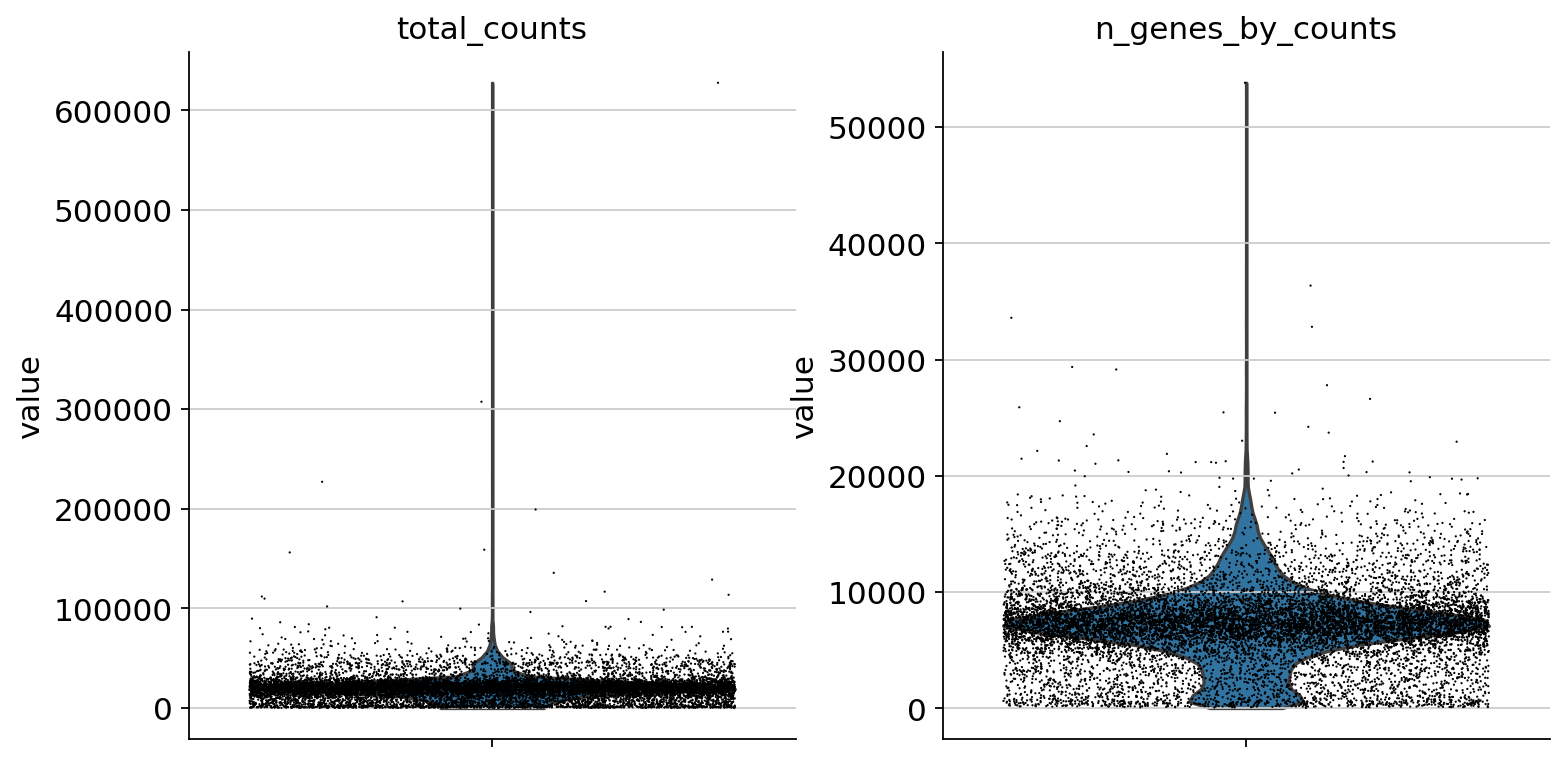

In [69]:
sc.pl.violin(atac, ["total_counts", "n_genes_by_counts"], jitter=0.4, multi_panel=True)

Filter peaks whose expression is not detected.

In [70]:
mu.pp.filter_var(atac, "n_cells_by_counts", lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

We also filter the cells.

In [71]:
mu.pp.filter_obs(atac, "n_genes_by_counts", lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, "total_counts", lambda x: (x >= 4000) & (x <= 40000))

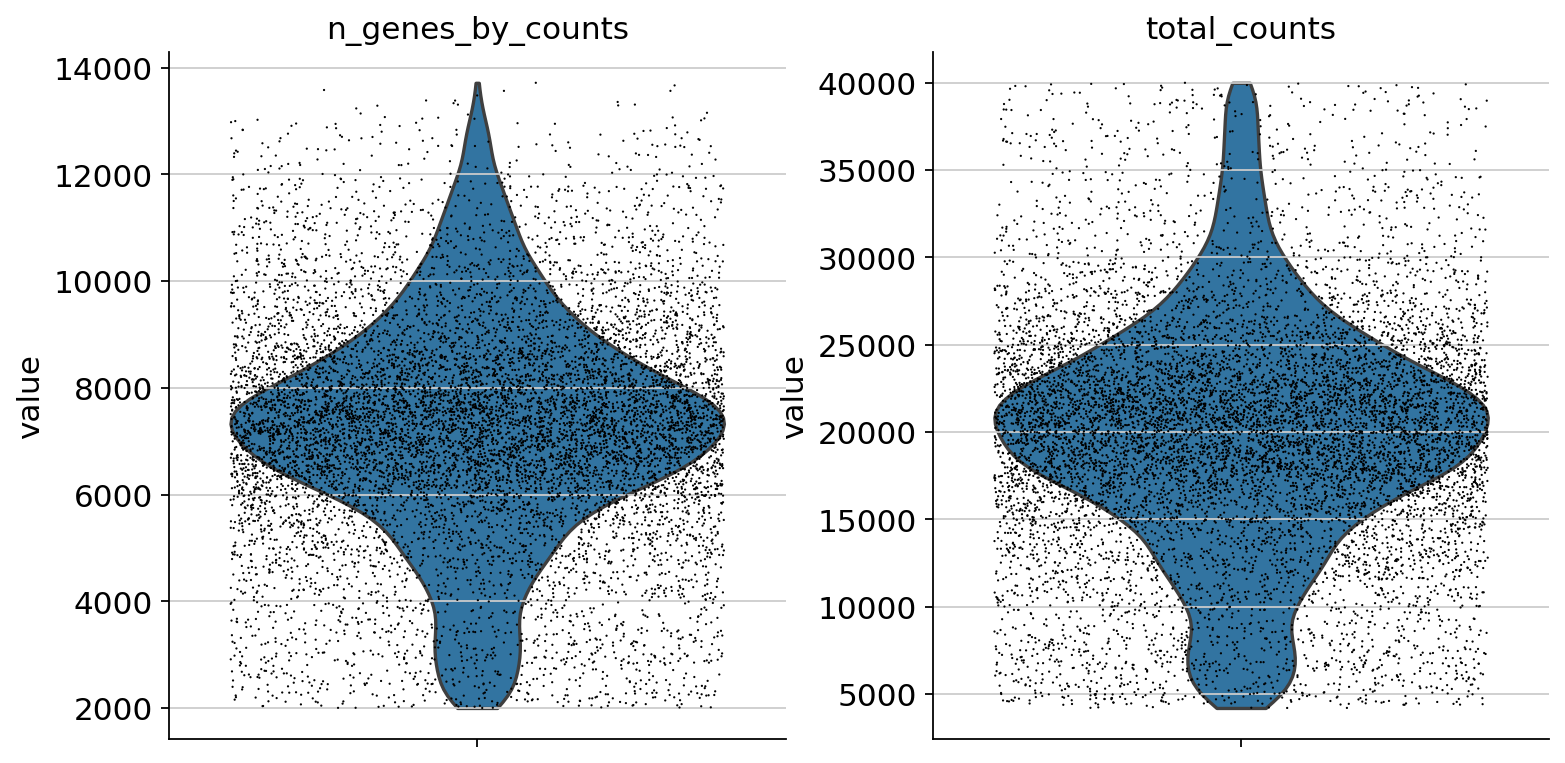

In [72]:
sc.pl.violin(atac, ["n_genes_by_counts", "total_counts"], jitter=0.4, multi_panel=True)

muon also provides histograms which allows for a different view on the metrics.

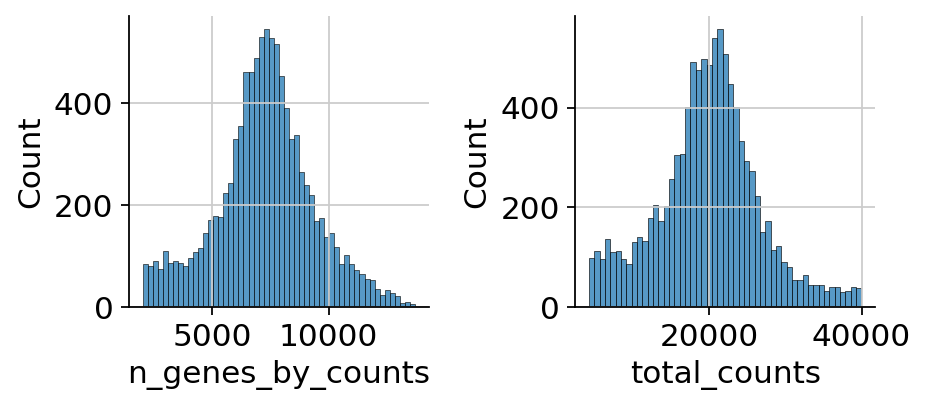

In [73]:
mu.pl.histogram(atac, ["n_genes_by_counts", "total_counts"])

Now that we rudimentary filtered out cells with too few peaks and peaks detected in too few cells, we can start with ATAC specific quality control with muon. muon has modality specific preprocessing functions in corresponding modules. We import the ATAC module to access the ATAC specific preprocessing functions.

In [74]:
from muon import atac as ac

Fetching Regions...: 100%|██████████| 1000/1000 [00:19<00:00, 50.03it/s]


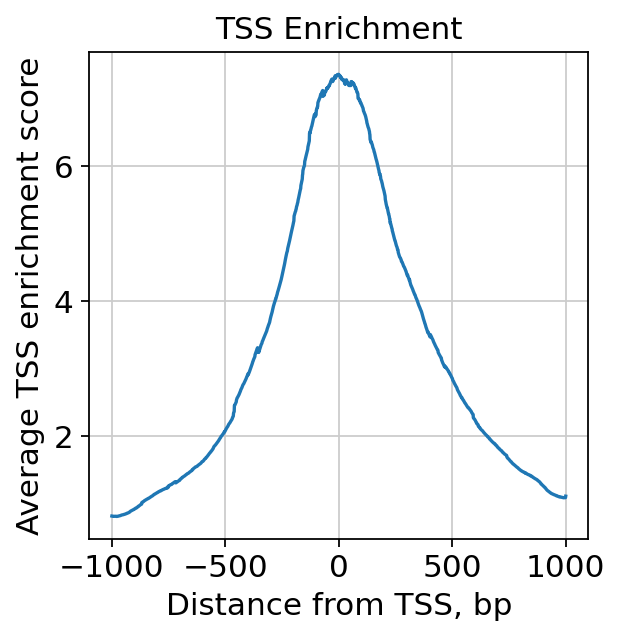

In [75]:
# Perform rudimentary quality control with muon's ATAC module
atac.obs["NS"] = 1
ac.tl.nucleosome_signal(atac, n=1e6)
ac.tl.get_gene_annotation_from_rna(mdata["rna"]).head(3)
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)
ac.pl.tss_enrichment(tss)

In [76]:
# Save original counts, normalize data and select highly variable genes with scanpy
atac.layers["counts"] = atac.X
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=0.5)
atac.raw = atac

Although PCA is also commonly used for ATAC data, latent semantic indexing (LSI) is another popular option. It is implemented in muon's ATAC module.

In [77]:
ac.tl.lsi(atac)

In [78]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [79]:
sc.tl.leiden(atac, resolution=0.5)

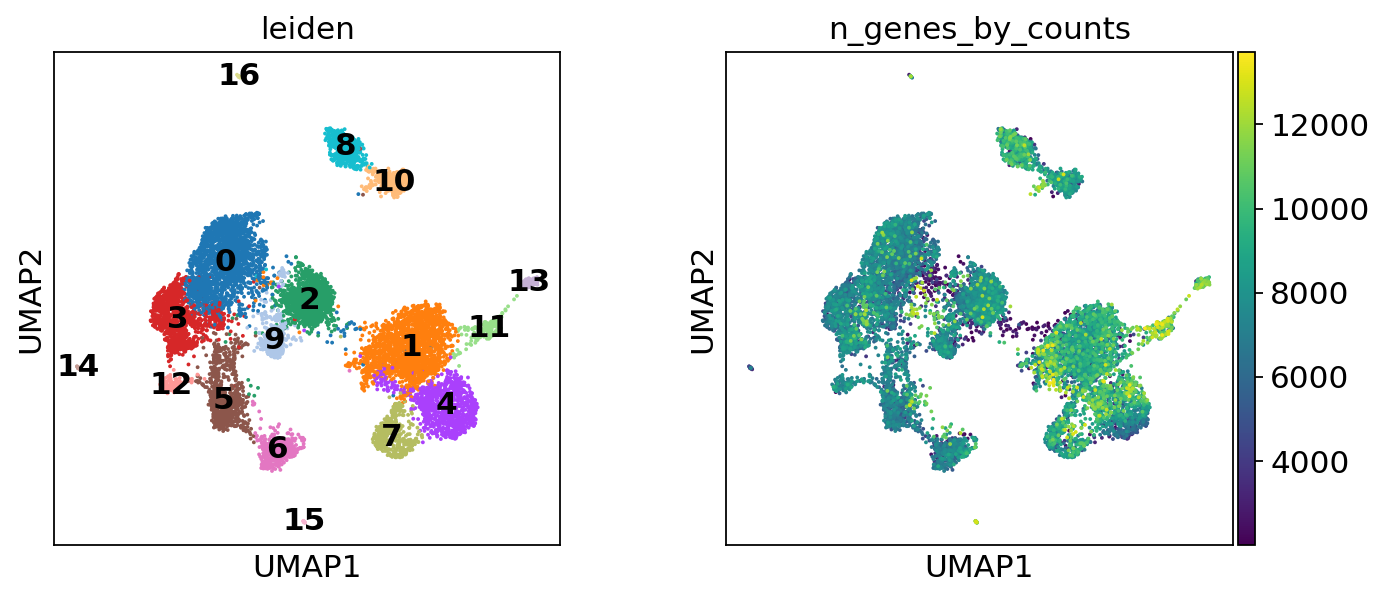

In [80]:
sc.tl.umap(atac, spread=1.5, min_dist=0.5, random_state=20)
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

We can use the functionality of the ATAC module in muon to color plots by cut values in peaks corresponding to a certain gene.

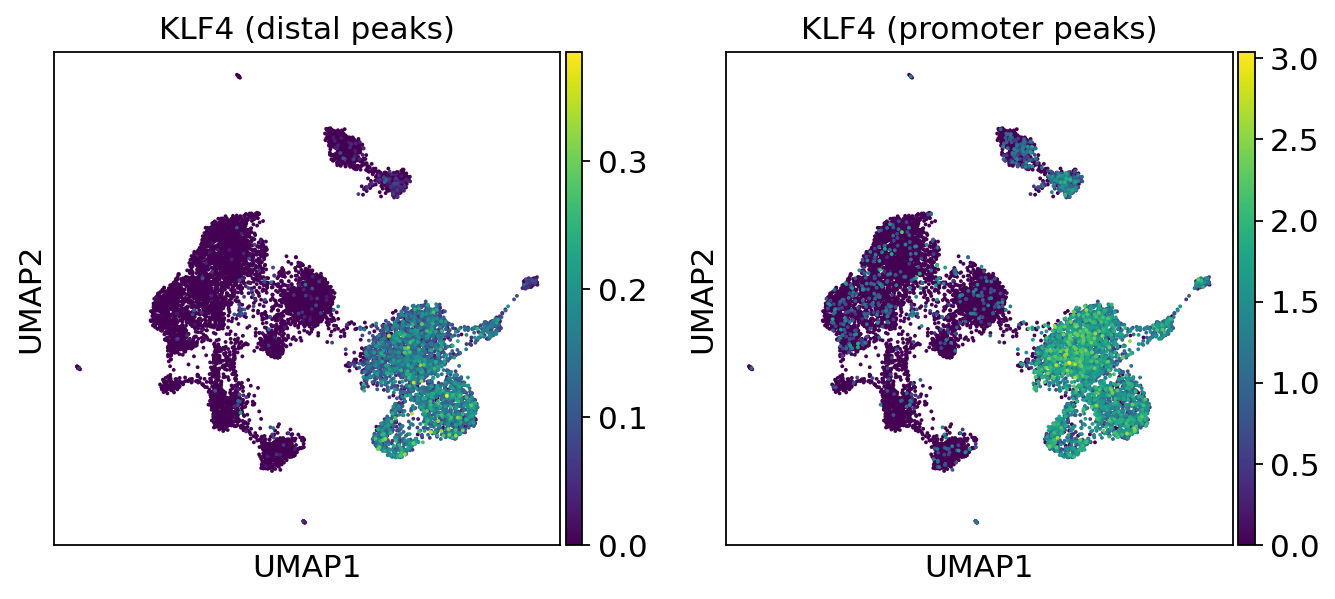

In [81]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

For more details on all available functions of muon, please read the muon API reference at https://muon.readthedocs.io/en/latest/api/index.html and the muon tutorials at https://muon-tutorials.readthedocs.io/en/latest/.

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: at
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Lukas Heumos

### Reviewers

* Isaac Virshup